In [1]:
# Importing the useful libararies
import os
import numpy as np 
import sys
import pandas as pd
from tensorflow.keras.optimizers import Adam
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Conv1D, MaxPooling1D,Bidirectional,Dropout
from sklearn.model_selection import train_test_split
#from tensorflow.keras.utils.np_utils import to_categorical
import gc
from tensorflow.keras import backend as K
from tensorflow.keras.backend import clear_session

#from keras.utils import plot_model

import matplotlib.pyplot as plt
%matplotlib inline

#exec(open("slim21.py" ).read())



In [2]:
#importing the News aggregator dataset
df = pd.read_csv('uci-news-aggregator.csv')

print (df.shape)
df.head()

(422419, 8)


,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


In [3]:
# removing duplicate titles if any 
print ( "before removing duplicate titles \n",df.CATEGORY.value_counts())
df = df.drop_duplicates( subset = ['TITLE'] )
print ( "after removing duplicate titles \n", df.CATEGORY.value_counts())

before removing duplicate titles 
 e    152469
b    115967
t    108344
m     45639
Name: CATEGORY, dtype: int64
after removing duplicate titles 
 e    146862
b    111669
t    104291
m     43633
Name: CATEGORY, dtype: int64


In [4]:
#extracting a random sample for model development
dt = df[['CATEGORY', 'TITLE']].sample(50000, random_state = 22)
dt.shape
cat_count = pd.DataFrame(dt.CATEGORY.value_counts())
cat_count

,CATEGORY
e,17943
b,13648
t,12976
m,5433


Text(0.5, 1.0, 'Count of News Articles in each Category')

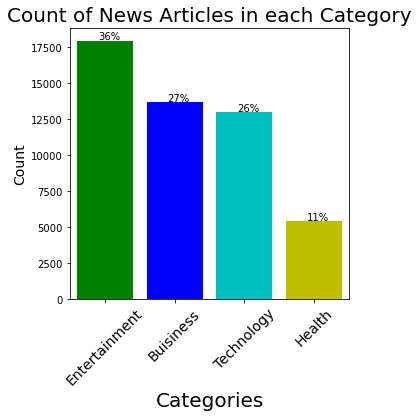

In [5]:
#plotting the distribution of counts of categories
plt.bar(cat_count.index,cat_count['CATEGORY'], color = ['g','b','c','y'])


ax = cat_count['CATEGORY'].plot(kind='bar' ,color = ['g','b','c','y'],figsize=(5,5), edgecolor=None)

for p in ax.patches[:4]:
    width, height = p.get_width(), p.get_height()
    perc = height/cat_count['CATEGORY'].sum()
    x, y = p.get_xy() 
    ax.annotate('{:.0%}'.format(perc), (x+0.3, y + height + 70))


plt.xticks(cat_count.index,['Entertainment' , 'Buisiness', 'Technology','Health'],rotation=45, fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Categories' ,  fontsize=20)
plt.title('Count of News Articles in each Category',   fontsize=20)


In [6]:
#using tokenizer library to convert text sentences to word tokens and subsequently converting them to numerical sequences
tokenizer = Tokenizer(num_words=10000, lower=True)

tokenizer.fit_on_texts(dt['TITLE'].values)
X = tokenizer.texts_to_sequences(dt['TITLE'].values)
X = pad_sequences(X, 10)

#converting the dependent categorical variable using one-hot encoding to numerical array
Y = pd.get_dummies(dt['CATEGORY']).values
np.set_printoptions(threshold=sys.maxsize)

#Splitting the dataset into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 22)

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(35000, 10) (35000, 4)
(15000, 10) (15000, 4)


In [7]:
#0:b, 1:e, 2:m, 3:t
print (pd.DataFrame(Y_train).sum())
print (pd.DataFrame(Y_test).sum())


0     9549
1    12446
2     3815
3     9190
dtype: int64
0    4099
1    5497
2    1618
3    3786
dtype: int64


In [8]:
# how the data looks
print (X[0:4])
Y[0:4]


[[   0    0   18  428  962  439 9800    5   50  204]
 [   1    3 3270  209  151 1031 1315 1284    6  100]
 [   0    0  260  361 1549 7857 7858   15 9801  312]
 [ 936  294    1 2343  792  378  861    1  664  563]]


array([[0, 0, 0, 1],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0]], dtype=uint8)

In [9]:

seed = 22
np.random.seed(seed)
model = Sequential()
model.add(Embedding(10000, 64,input_length = X_train.shape[1] ))
model.add(SpatialDropout1D(0.7 ))
model.add(Conv1D(64,5,padding='valid',activation='relu',strides=1))
model.add(MaxPooling1D(pool_size=2 ))
#model.add(sl.LSTMs(implementation= 1,return_sequences=False,units=64,activation= 'sigmoid',input_shape=X_train.shape[1:], model='LSTM3'))
model.add(LSTM(64, activation ='relu'))#, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.5 ))
model.add(Dense(4,activation='softmax'))
adam = Adam(lr = 0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0 )
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

hist = model.fit(X_train, Y_train, epochs= 20,verbose=1 , batch_size= 500,validation_data=(X_test, Y_test) ,shuffle=False)

gc.collect()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 64)            640000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 10, 64)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 6, 64)             20544     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 2

6905

In [10]:
import skopt
# !pip install scikit-optimize if  necessary
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer  

In [12]:
dim_learning_rate = Real(low=1e-4, high=1e-2, prior='log-uniform',
                         name='learning_rate')
#dim_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')
#dim_num_input_nodes = Integer(low=1, high=512, name='num_input_nodes')
#dim_num_dense_nodes = Integer(low=1, high=28, name='num_dense_nodes')
dim_activation = Categorical(categories=['relu', 'sigmoid'],
                             name='activation')
dim_batch_size = Integer(low=1, high=128, name='batch_size')
dim_adam_decay = Real(low=1e-6,high=1e-2,name="adam_decay")

dimensions = [dim_learning_rate,
              dim_activation,
              dim_batch_size,
              dim_adam_decay
             ]
default_parameters = [1e-3,'relu',64, 1e-3]

In [24]:
import tensorflow as tf

def create_model(learning_rate, activation, adam_decay):
    #start the model making process and create our first layer
    model = Sequential()
    model.add(Embedding(10000, 64,input_length = X_train.shape[1] ))
    model.add(SpatialDropout1D(0.7 ))
    model.add(Conv1D(64,5,padding='valid',activation=activation,strides=1))
    model.add(MaxPooling1D(pool_size=2 ))
    #model.add(sl.LSTMs(implementation= 1,return_sequences=False,units=64,activation= 'sigmoid',input_shape=X_train.shape[1:], model='LSTM3'))
    model.add(LSTM(64, activation =activation))#, dropout=0.5, recurrent_dropout=0.5))
    model.add(Dropout(0.5 ))
    model.add(Dense(4,activation='softmax'))
    adam = Adam(lr = learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=adam_decay)
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

    return model

In [29]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate,activation, batch_size,adam_decay):

    model = create_model(learning_rate=learning_rate,
                         activation=activation,
                         adam_decay=adam_decay
                        )
    

    #named blackbox becuase it represents the structure
    blackbox = model.fit(X_train, Y_train, epochs= 20,verbose=1 , batch_size= batch_size,validation_data=(X_test, Y_test) ,shuffle=False)
    
    #blackbox = model.fit(x=X_train,
    #                    y=y_train,
    #                    epochs=3,
    #                    batch_size=batch_size,
    #                    validation_split=0.15,
    #                    )
    #return the validation accuracy for the last epoch.
    #accuracy = blackbox.history['val_acc'][-1]

    # Print the classification accuracy.
    #print()
    #print("Accuracy: {0:.2%}".format(accuracy))
    #print()


    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    #tf.reset_default_graph()
    
    # the optimizer aims for the lowest score, so we return our negative accuracy
    #return -accuracy

In [30]:
gp_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            n_calls=12,
                            noise= 0.01,
                            n_jobs=-1,
                            kappa = 5,
                            x0=default_parameters)

Epoch 1/20
547/547 [==============================] - 5s 7ms/step - loss: 1.1208 - accuracy: 0.4819 - val_loss: 0.4336 - val_accuracy: 0.8627
Epoch 2/20
547/547 [==============================] - 12s 22ms/step - loss: 0.4583 - accuracy: 0.8454 - val_loss: 0.3304 - val_accuracy: 0.8921
Epoch 3/20
547/547 [==============================] - 11s 19ms/step - loss: 0.3188 - accuracy: 0.8942 - val_loss: 0.3047 - val_accuracy: 0.9005
Epoch 4/20
547/547 [==============================] - 11s 19ms/step - loss: 0.2554 - accuracy: 0.9139 - val_loss: 0.3037 - val_accuracy: 0.9051
Epoch 5/20
547/547 [==============================] - 9s 17ms/step - loss: 0.2194 - accuracy: 0.9288 - val_loss: 0.3052 - val_accuracy: 0.9039
Epoch 6/20
547/547 [==============================] - 9s 16ms/step - loss: 0.1859 - accuracy: 0.9378 - val_loss: 0.3179 - val_accuracy: 0.9041
Epoch 7/20
547/547 [==============================] - 9s 17ms/step - loss: 0.1762 - accuracy: 0.9423 - val_loss: 0.3285 - val_accuracy: 0.90

ValueError: expected y to be a list of scalars

In [18]:
gp_result.x[0]

NameError: name 'gp_result' is not defined

In [ ]:
import time